# Online Gradient Descent Based Portfolio Optimizer


This notebook extends upon Week 9's notebook by incorporating some ideas we talked about during the latest check in, such as running gradient descent over hyperparameters.

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [ ]:
# Define the Magnificent 7 tickers
tickers = [
    # Technology & AI
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "AVGO", "ORCL", "IBM", "CSCO",

    # Financials & Banking
    "JPM", "V", "MA", "GS", "MS", "BAC", "C", "AXP", "SCHW",

    # Healthcare & Pharma
    "UNH", "JNJ", "LLY", "PFE", "MRNA", "BMY", "GILD", "CVS", "VRTX", "ISRG",

    # Consumer Goods & Retail
    "WMT", "NKE", "PG", "TGT", "COST", "KO", "PEP", "MCD", "SBUX", "YUM",

    # Energy & Utilities
    "XOM", "CVX", "NEE", "DUK", "SO", "D", "ENB", "SLB", "EOG", "PSX",

    # Industrials & Defense
    "DE", "LMT", "RTX", "BA", "CAT", "GE", "HON", "UPS", "EMR", "NOC",

    # Real Estate & Infrastructure
    "PLD", "AMT", "EQIX", "O", "SPG", "VICI", "DLR", "WY", "EQR", "PSA",

    # Transportation & Automotive
    "TSLA", "FDX", "UPS", "GM", "F", "RIVN", "NIO", "CSX", "UNP", "DAL",

    # Semiconductors
    "TSM", "ASML", "AMD", "TXN", "INTC", "MU", "QCOM", "LRCX", "NXPI", "ADI",

    # Agriculture & Food
    "ADM", "BG", "CF", "TSN", "MOS", "FMC", "CAG", "SYY", "HRL", "MDLZ",

    # Entertainment & Media
    "NFLX", "DIS", "PARA", "WBD", "CMCSA", "SPOT", "LYV", "TTWO", "EA",

    # Meme Stocks
    "GME", "AMC"
]

# Fetch historical price data for 2022-2023 (training period)
train_start_date = "2022-01-01"
train_end_date = "2023-12-31"

# Fetch historical price data for 2024 (testing period)
test_start_date = "2024-01-01"
test_end_date = datetime.now().strftime("%Y-%m-%d")  # Today's date

print(f"Training period: {train_start_date} to {train_end_date}")
print(f"Testing period: {test_start_date} to {test_end_date}")

# Download adjusted close prices for both periods
train_prices = yf.download(tickers, start=train_start_date, end=train_end_date)["Close"]
test_prices = yf.download(tickers, start=test_start_date, end=test_end_date)["Close"]

print(f"Training data shape: {train_prices.shape}")
print(f"Testing data shape: {test_prices.shape}")

# Check for missing values
print(f"Missing values in training data: {train_prices.isna().sum().sum()}")
print(f"Missing values in testing data: {test_prices.isna().sum().sum()}")

# Fill any missing values with forward fill, then backward fill
train_prices = train_prices.fillna(method='ffill').fillna(method='bfill')
test_prices = test_prices.fillna(method='ffill').fillna(method='bfill')

Training period: 2022-01-01 to 2023-12-31
Testing period: 2024-01-01 to 2025-04-05
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  109 of 109 completed
[*********************100%***********************]  109 of 109 completed
<ipython-input-2-be3cf51292d9>:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_prices = train_prices.fillna(method='ffill').fillna(method='bfill')


Training data shape: (501, 109)
Testing data shape: (316, 109)
Missing values in training data: 0
Missing values in testing data: 0


<ipython-input-2-be3cf51292d9>:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_prices = test_prices.fillna(method='ffill').fillna(method='bfill')


In [15]:
# Import the OnlinePortfolioOptimizer class from the previous code
class OnlinePortfolioOptimizer:
    def __init__(self,
                 n_assets,
                 initial_learning_rate=0.01,
                 decay_rate=0.995,
                 momentum=0.9,
                 window_size=252,
                 alphas=(1.0, 1.0, 1.0, 0.5, 0.2),
                 transaction_penalty_factor=0.1,
                 sparsity_factor=0.05):

        self.n_assets = n_assets
        self.initial_lr = initial_learning_rate
        self.current_lr = initial_learning_rate
        self.decay_rate = decay_rate
        self.momentum = momentum
        self.window_size = int(window_size) if window_size is not None else 252
        self.alphas = alphas
        self.transaction_penalty_factor = transaction_penalty_factor
        self.sparsity_factor = sparsity_factor

        # Store previous weights for transaction cost calculation
        self.previous_weights = None

        # Initialize weights equally
        self.weights = torch.ones(n_assets) / n_assets
        self.velocity = torch.zeros(n_assets)
        self.t = 0

    def _decay_learning_rate(self):
        self.current_lr = self.initial_lr * (self.decay_rate ** self.t)

    def _calculate_expected_returns_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        expected_returns = returns.mean()
        grad = expected_returns / 0.5
        return torch.tensor(grad.values, dtype=torch.float32)

    def _calculate_sortino_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        portfolio_returns = torch.matmul(torch.tensor(returns.values, dtype=torch.float32), self.weights)

        rf_daily = 0.02 / 252
        excess_returns = torch.tensor(returns.values, dtype=torch.float32) - rf_daily

        # Find indices where portfolio returns are negative
        negative_mask = portfolio_returns < 0
        negative_returns = excess_returns[negative_mask]

        if len(negative_returns) > 0:
            downside_std = torch.sqrt(torch.mean(torch.square(negative_returns)))
        else:
            downside_std = torch.tensor(1e-6)

        grad = (torch.mean(excess_returns, dim=0) / (3.0 * downside_std))
        return grad

    def _calculate_drawdown_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()

        # Convert returns to torch tensor
        returns_tensor = torch.tensor(returns.values, dtype=torch.float32)

        # Calculate cumulative returns for the portfolio
        portfolio_returns = torch.matmul(returns_tensor, self.weights)
        cumulative_returns = torch.cumprod(1 + portfolio_returns, dim=0)

        # Find the maximum drawdown point
        peak = torch.cummax(cumulative_returns, dim=0)[0]
        drawdown = cumulative_returns / peak - 1
        max_dd_idx = torch.argmin(drawdown)

        # Calculate gradient
        if max_dd_idx > 0:
            grad = -torch.mean(returns_tensor[:max_dd_idx+1], dim=0)
        else:
            grad = torch.zeros(self.n_assets)

        return grad

    def _project_onto_simplex(self, weights):
        if torch.sum(weights) <= 0:
            return torch.ones(self.n_assets) / self.n_assets

        sorted_weights, _ = torch.sort(weights, descending=True)
        cumulative_sum = torch.cumsum(sorted_weights, dim=0)

        k = 1
        for i in range(1, len(weights) + 1):
            v_k = (cumulative_sum[i-1] - 1) / i
            if i == len(weights) or sorted_weights[i] <= v_k:
                k = i
                break

        threshold = v_k
        return torch.maximum(weights - threshold, torch.zeros_like(weights))

    def step(self, prices_df, verbose=True):
        if len(prices_df) < self.window_size:
            if verbose:
                print(f"Insufficient data points ({len(prices_df)}/{self.window_size}). Returning current weights.")
            return self.weights

        self.t += 1
        prev_lr = self.current_lr
        self._decay_learning_rate()

        if verbose:
            print(f"\n===== Optimization Step {self.t} =====")
            print(f"Learning rate: {prev_lr:.6f} → {self.current_lr:.6f}")

            if self.previous_weights is not None:
                # Calculate portfolio sparsity metrics
                nonzero_positions = (self.weights > 0.001).sum().item()
                l1_norm = torch.sum(torch.abs(self.weights)).item()
                print(f"Current portfolio stats:")
                print(f"  Active positions (>0.1%): {nonzero_positions} / {self.n_assets}")
                print(f"  L1 norm: {l1_norm:.4f}")

            # Log current portfolio stats
            weights_list = self.weights.cpu().tolist()
            top_holdings = [(idx, w) for idx, w in sorted(
                enumerate(weights_list), key=lambda x: x[1], reverse=True) if w > 0.01]

            if top_holdings:
                print("Current top holdings (>1%):")
                for idx, weight in top_holdings[:5]:  # Show top 5
                    ticker = prices_df.columns[idx]
                    print(f"  {ticker}: {weight*100:.2f}%")

                print(f"Portfolio concentration (HHI): {(self.weights**2).sum().item()*10000:.2f}")

        try:
            # Calculate gradients
            er_grad = self._calculate_expected_returns_gradient(prices_df)
            sortino_grad = self._calculate_sortino_gradient(prices_df)
            dd_grad = self._calculate_drawdown_gradient(prices_df)

            if verbose:
                # Log gradient magnitudes for each component
                er_norm = torch.norm(er_grad).item()
                sortino_norm = torch.norm(sortino_grad).item()
                dd_norm = torch.norm(dd_grad).item()

                print("\nGradient components:")
                print(f"  Expected returns gradient magnitude: {er_norm:.4f}")
                print(f"  Sortino ratio gradient magnitude: {sortino_norm:.4f}")
                print(f"  Drawdown gradient magnitude: {dd_norm:.4f}")

                # Identify stocks with the largest gradients
                for grad_name, grad in [("Expected returns", er_grad),
                                       ("Sortino", sortino_grad),
                                       ("Drawdown", dd_grad)]:

                    top_idx = torch.argsort(grad, descending=True)[:3]
                    print(f"\n  Top 3 positive {grad_name} signals:")
                    for idx in top_idx:
                        # Convert PyTorch tensor index to Python int for DataFrame indexing
                        idx_int = idx.item()
                        ticker = prices_df.columns[idx_int]
                        print(f"    {ticker}: {grad[idx].item():.4f}")

            # Store current weights for transaction penalty calculation
            old_weights = self.weights.clone()

            # Calculate transaction cost penalty gradient (if we have previous weights)
            if self.previous_weights is not None:
                transaction_penalty_grad = -torch.sign(old_weights - self.previous_weights) * self.transaction_penalty_factor

                if verbose:
                    penalty_magnitude = torch.norm(transaction_penalty_grad).item()
                    print(f"\nTransaction penalty gradient magnitude: {penalty_magnitude:.4f}")
            else:
                transaction_penalty_grad = torch.zeros_like(old_weights)
                if verbose:
                    print("\nNo transaction penalty for first step (no previous weights)")

            # Calculate L1 sparsity gradient
            l1_sparsity_grad = -torch.sign(old_weights) * self.sparsity_factor

            if verbose:
                sparsity_magnitude = torch.norm(l1_sparsity_grad).item()
                print(f"L1 sparsity gradient magnitude: {sparsity_magnitude:.4f}")

            # Combine all gradients using alpha weights
            total_grad = (self.alphas[0] * er_grad +
                         self.alphas[1] * sortino_grad -
                         self.alphas[2] * dd_grad +
                         self.alphas[3] * transaction_penalty_grad +
                         self.alphas[4] * l1_sparsity_grad)

            # Update velocity and weights
            old_velocity = self.velocity.clone()
            self.velocity = self.momentum * old_velocity + self.current_lr * total_grad

            if verbose:
                print("\nMomentum update:")
                print(f"  Momentum factor: {self.momentum:.4f}")
                print(f"  Velocity change magnitude: {torch.norm(self.velocity - old_velocity).item():.4f}")

            new_weights = old_weights + self.velocity

            # Calculate transaction costs for reporting only (no hard constraint anymore)
            costs = torch.sum(torch.abs(new_weights - old_weights)) * 0.001

            if verbose:
                print(f"\nTransaction costs: {costs*100:.4f}%")

            # Store current weights as previous for next iteration
            self.previous_weights = old_weights.clone()

            # Project onto simplex
            self.weights = self._project_onto_simplex(new_weights)

            if verbose:
                # Log biggest weight changes
                weight_changes = self.weights - old_weights
                increase_idx = torch.argsort(weight_changes, descending=True)[:3]
                decrease_idx = torch.argsort(weight_changes)[:3]

                print("\nBiggest position increases:")
                for idx in increase_idx:
                    # Convert PyTorch tensor index to Python int
                    idx_int = idx.item()
                    ticker = prices_df.columns[idx_int]
                    old_pct = old_weights[idx].item() * 100
                    new_pct = self.weights[idx].item() * 100
                    print(f"  {ticker}: {old_pct:.2f}% → {new_pct:.2f}% (Δ{new_pct-old_pct:+.2f}%)")

                print("\nBiggest position decreases:")
                for idx in decrease_idx:
                    # Convert PyTorch tensor index to Python int
                    idx_int = idx.item()
                    ticker = prices_df.columns[idx_int]
                    old_pct = old_weights[idx].item() * 100
                    new_pct = self.weights[idx].item() * 100
                    print(f"  {ticker}: {old_pct:.2f}% → {new_pct:.2f}% (Δ{new_pct-old_pct:+.2f}%)")

        except Exception as e:
            print(f"Error in step: {e}")
            import traceback
            traceback.print_exc()
            # Return current weights if there's an error

        return self.weights

    def get_weights(self):
        return self.weights

In [17]:
def evaluate_hyperparams(prices_df, hyperparams, steps=30):
    optimizer = OnlinePortfolioOptimizer(
        n_assets=prices_df.shape[1],
        initial_learning_rate=hyperparams["initial_learning_rate"],
        decay_rate=hyperparams["decay_rate"],
        momentum=hyperparams["momentum"],
        window_size=hyperparams["window_size"],
    )
    weights = None
    for i in range(steps):
        sub_df = prices_df.iloc[:optimizer.window_size + i]
        weights = optimizer.step(sub_df, verbose=False)

    # Evaluate using cumulative return
    returns = prices_df.pct_change().dropna()
    portfolio_returns = (returns @ weights.numpy()).cumsum()
    return portfolio_returns.iloc[-1]


def hyperparam_gradient_descent(prices_df, initial_params, lr=0.01, n_iter=10):
    params = initial_params.copy()
    keys = list(params.keys())
    history = []

    for iteration in range(n_iter):
        grads = {}
        base_score = evaluate_hyperparams(prices_df, params)

        # Log the current state
        record = {"iteration": iteration + 1, "score": base_score}
        record.update(params.copy())
        history.append(record)

        for key in keys:
            eps = 1e-3
            perturbed = params.copy()
            perturbed[key] += eps

            # Clip
            if "momentum" in key or "decay" in key:
                perturbed[key] = min(max(perturbed[key], 0), 1)
            if "window_size" in key:
                perturbed[key] = max(30, int(perturbed[key]))

            score = evaluate_hyperparams(prices_df, perturbed)
            grads[key] = (score - base_score) / eps

        for key in keys:
            params[key] += lr * grads[key]

    return params, history

import matplotlib.pyplot as plt

def plot_hyperparam_optimization(history):
    """
    history: List of dicts, where each dict contains:
      - 'iteration': int
      - 'score': float
      - each hyperparam: float
    """
    if not history:
        print("No optimization history to plot.")
        return

    keys = [k for k in history[0].keys() if k != 'iteration' and k != 'score']
    iterations = [h['iteration'] for h in history]
    scores = [h['score'] for h in history]

    fig, axs = plt.subplots(len(keys) + 1, 1, figsize=(8, 4 * (len(keys) + 1)))

    # Plot score
    axs[0].plot(iterations, scores, marker='o')
    axs[0].set_title("Performance Metric Over Iterations")
    axs[0].set_ylabel("Score (e.g., cumulative return)")
    axs[0].grid(True)

    # Plot each hyperparameter
    for i, key in enumerate(keys):
        values = [h[key] for h in history]
        axs[i+1].plot(iterations, values, marker='o')
        axs[i+1].set_title(f"{key} Over Iterations")
        axs[i+1].set_ylabel(key)
        axs[i+1].grid(True)

    plt.xlabel("Iteration")
    plt.tight_layout()
    plt.show()


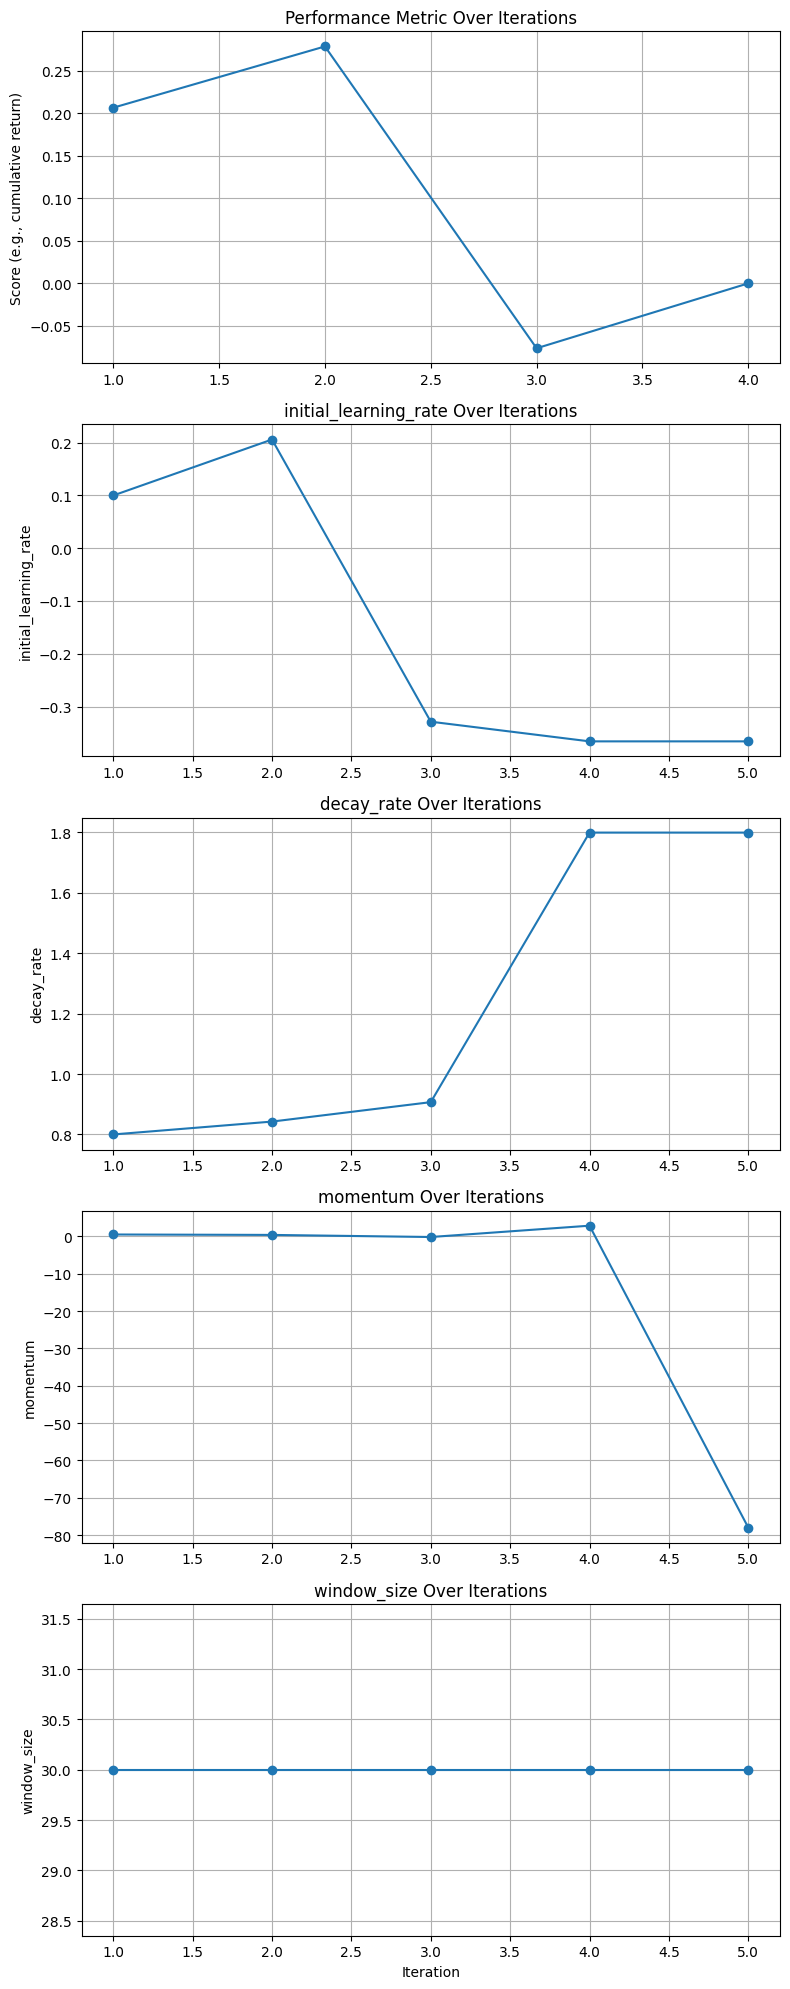

In [18]:
initial_hyperparams = {
    "initial_learning_rate": 0.10,
    "decay_rate": 0.80,
    "momentum": 0.5,
    "window_size": 30,
}

best_params, history = hyperparam_gradient_descent(train_prices, initial_hyperparams, lr=0.1, n_iter=5)
plot_hyperparam_optimization(history)